<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-all-the-things" data-toc-modified-id="Import-all-the-things-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import all the things</a></span></li></ul></div>

Business case: There will be a foodie fair in your city next summer (if coronavirus allows it to do), and the organsers have contacted us because they are interested in performing an analysis of the world wide cuisines. They manage to obtain a dataset from different cuisines all over the world, together with the list of the most common ingredients.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

# Import all the things

In [1]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

C:\Users\Stacy\anaconda3\envs\DataAnalytics\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Stacy\anaconda3\envs\DataAnalytics\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Stacy\anaconda3\envs\DataAnalytics\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [1]:
import sys
sys.path.insert(0, r"C:\Users\Stacy\Documents\_Bootcamp\functions")

from functions_EDA import *

C:\Users\Stacy\anaconda3\envs\DataAnalytics\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Stacy\anaconda3\envs\DataAnalytics\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Stacy\anaconda3\envs\DataAnalytics\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
train = pd.read_json('P3.foodie_dataset.json').drop('id', axis = 1)
train.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'books.csv'

In [4]:
get_info_dataset(train)

Basic information from your dataset
 ---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cuisine      39774 non-null  object
 1   ingredients  39774 non-null  object
dtypes: object(2)
memory usage: 621.6+ KB

Numerical variables are:
 Index([], dtype='object')
-------------------------------------------------
Categorical variables are:
 Index(['cuisine', 'ingredients'], dtype='object')
-------------------------------------------------


(Index([], dtype='object'), Index(['cuisine', 'ingredients'], dtype='object'))

In [5]:
train.isnull().sum()

cuisine        0
ingredients    0
dtype: int64

<AxesSubplot:>

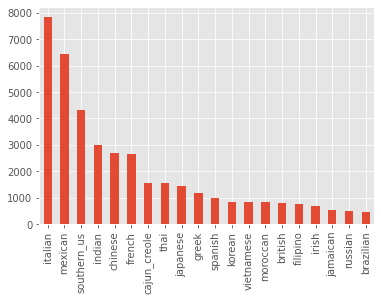

In [6]:
plt.style.use('ggplot')
train['cuisine'].value_counts().plot(kind='bar')

In [7]:
train_count={}
for i in range(len(train)):
    for j in train['ingredients'][i]:
        if j in train_count.keys():
            train_count[j]+=1
        else:
            train_count[j]=1

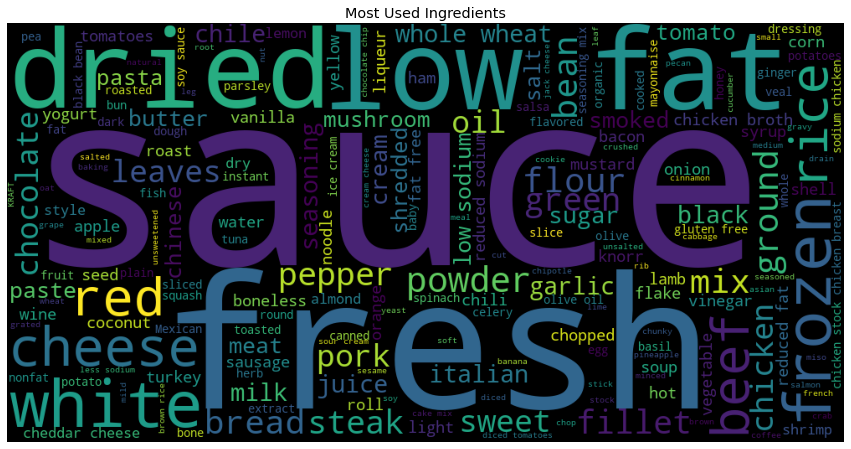

In [8]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(train_count))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Most Used Ingredients")
plt.axis("off")
plt.show()

In [9]:
train.ingredients = train['ingredients'].apply(','.join)

In [10]:
train.ingredients = train['ingredients'].str.lower()

In [11]:
train.ingredients= train['ingredients'].str.replace(r"[^A-Za-z0-9(),!?&@\'\`\"\_\n]", " ")

In [12]:
train['ingredients_txt'] = train['ingredients'].str.replace(' ','_')
train

,cuisine,ingredients,ingredients_txt
0,greek,"romaine lettuce,black olives,grape tomatoes,ga...","romaine_lettuce,black_olives,grape_tomatoes,ga..."
1,southern_us,"plain flour,ground pepper,salt,tomatoes,ground...","plain_flour,ground_pepper,salt,tomatoes,ground..."
2,filipino,"eggs,pepper,salt,mayonaise,cooking oil,green c...","eggs,pepper,salt,mayonaise,cooking_oil,green_c..."
3,indian,"water,vegetable oil,wheat,salt","water,vegetable_oil,wheat,salt"
4,indian,"black pepper,shallots,cornflour,cayenne pepper...","black_pepper,shallots,cornflour,cayenne_pepper..."
...,...,...,...
39769,irish,"light brown sugar,granulated sugar,butter,warm...","light_brown_sugar,granulated_sugar,butter,warm..."
39770,italian,"kraft zesty italian dressing,purple onion,broc...","kraft_zesty_italian_dressing,purple_onion,broc..."
39771,irish,"eggs,citrus fruit,raisins,sourdough starter,fl...","eggs,citrus_fruit,raisins,sourdough_starter,fl..."
39772,chinese,"boneless chicken skinless thigh,minced garlic,...","boneless_chicken_skinless_thigh,minced_garlic,..."


In [13]:
cv = CountVectorizer(ngram_range=(1,2), max_df = 0.5, min_df = 0.05)
dt_mat = cv.fit_transform(train.ingredients)

In [14]:
train.tail(10)

,cuisine,ingredients,ingredients_txt
39764,mexican,"chili powder,worcestershire sauce,celery,red k...","chili_powder,worcestershire_sauce,celery,red_k..."
39765,indian,"coconut,unsweetened coconut milk,mint leaves,p...","coconut,unsweetened_coconut_milk,mint_leaves,p..."
39766,irish,"rutabaga,ham,thick cut bacon,potatoes,fresh pa...","rutabaga,ham,thick_cut_bacon,potatoes,fresh_pa..."
39767,italian,"low fat sour cream,grated parmesan cheese,salt...","low_fat_sour_cream,grated_parmesan_cheese,salt..."
39768,mexican,"shredded cheddar cheese,crushed cheese cracker...","shredded_cheddar_cheese,crushed_cheese_cracker..."
39769,irish,"light brown sugar,granulated sugar,butter,warm...","light_brown_sugar,granulated_sugar,butter,warm..."
39770,italian,"kraft zesty italian dressing,purple onion,broc...","kraft_zesty_italian_dressing,purple_onion,broc..."
39771,irish,"eggs,citrus fruit,raisins,sourdough starter,fl...","eggs,citrus_fruit,raisins,sourdough_starter,fl..."
39772,chinese,"boneless chicken skinless thigh,minced garlic,...","boneless_chicken_skinless_thigh,minced_garlic,..."
39773,mexican,"green chile,jalapeno chilies,onions,ground bla...","green_chile,jalapeno_chilies,onions,ground_bla..."


In [15]:
train.groupby('cuisine').count()

,ingredients,ingredients_txt
cuisine,,
brazilian,467,467
british,804,804
cajun_creole,1546,1546
chinese,2673,2673
filipino,755,755
french,2646,2646
greek,1175,1175
indian,3003,3003
irish,667,667


In [16]:
list_corpus = train['ingredients'].tolist()

In [17]:
vectorizer = TfidfVectorizer()
vectorizer.fit(list_corpus)

TfidfVectorizer()

In [18]:
vector = vectorizer.transform(train['ingredients'])
max_value = vector.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

In [19]:
sorted_by_idf = np.argsort(vectorizer.idf_)
#print("Features with the lowest idf:\n{}".format(feature_names[sorted_by_idf[:50]]))
feature_names = np.array(vectorizer.get_feature_names())
#print("Features with the lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:100]]))

In [20]:
custom_stop_words = []
for word in ENGLISH_STOP_WORDS:
    custom_stop_words.append(word) 
    
custom_stop_words = custom_stop_words + feature_names[sorted_by_idf[:30]].tolist()

count_vect = CountVectorizer(stop_words=custom_stop_words)

In [21]:
counts = count_vect.fit_transform(train["ingredients"])  # sparse matrix with columns corresponding to words
words = count_vect.get_feature_names()  # array with words corresponding to columns

In [22]:
counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
from sklearn.cluster import KMeans
inertia = []

#First : Get the Best KMeans 
ks = range(1,20)

for i in ks:
    kmeans = KMeans(n_clusters= i, random_state=7)
    kmeans.fit(counts)
    inertia.append(kmeans.inertia_)

In [ ]:
# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertia, '-o')

plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()

In [ ]:
from kneed import KneeLocator
kl = KneeLocator(ks, inertia, curve="convex", direction="decreasing")
kl

print('The elbow point of your model is:', kl.elbow)

In [ ]:
# Final model with k=8
kmeans = KMeans(n_clusters=8, 
                max_iter=400, random_state=42)

kmeans.fit(counts)

In [ ]:
kmeans.labels_

In [ ]:
yPred = pd.DataFrame(kmeans.labels_)
yPred

In [ ]:
# assign the label
train['cluster_id'] = kmeans.labels_
train.head()

In [ ]:
train.groupby('cluster_id').count()

In [ ]:
def plot_clusters(df_sc, var1, var2,colors):
    """
    Function to plot each pair of variables after clustering it with Kmeans 
    
    input: df_sc -> scaled dataset
           var1 -> variable 1 (x axis)
           var2 -> variable 2 (y axis)
           colors -> list of the colors for the clusters
    """
 
    total_clusters = df_sc.cluster_id.nunique()     
    fig = px.scatter(df_sc, x = var1, 
                 y = var2, color = df_sc.columns[len(df_sc.columns)-1], 
                     color_continuous_scale=colors)
    fig.update_layout(coloraxis_showscale=False)
    fig.show()

In [ ]:
colors_clusters = ['Coral', 'DarkCyan', 'DarkSeaGreen', 
                   'Gold','Lightgreen']

In [ ]:
plot_clusters(train, 'ingredients', 'cuisine',colors_clusters)

In [ ]:
mean_clusters = train.groupby('cluster_id')
mean_clusters

In [ ]:
# Step 1: Create the traces of the plots
fig = px.bar(mean_clusters, x = 'cluster_id', 
                 y = 'MonetaryValue', color='cluster_id',
                 color_continuous_scale=  colors_clusters)

# Step 2: Update the layout of the plot
fig.update_layout(barmode ='group')

fig.show()